
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [18]:
import numpy as np

In [19]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [20]:
import gym
# Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [21]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [22]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [23]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    
    # End of episodes/goal/task where nextQs = 0 and Qs=rs
    dones = tf.placeholder(tf.bool, [None], name='dones') # masked

    # Qs = qs+ (gamma * nextQs)
    nextQs = tf.placeholder(tf.float32, [None], name='nextQs') # masked
    nextQs_D = tf.placeholder(tf.float32, [None], name='nextQs_D') # masked
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, dones, nextQs, nextQs_D

In [24]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [25]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [26]:
# The model loss for predicted/generated actions
def model_loss(prev_actions, states, actions, # model input data for Qs/qs/rs 
               nextQs, gamma, # model input data for targetQs
               state_size, action_size, hidden_size): # model init for Qs
    # Calculating Qs total rewards
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = generator(prev_actions=prev_actions_onehot, states=states, 
                                  hidden_size=hidden_size, state_size=state_size, action_size=action_size)
    
    # Masking actions_logits unmasked
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    
    # # Bellman equaion for calculating total rewards using current reward + total future rewards/nextQs
    # qs = tf.sigmoid(Qs) # qt
    # targetQs = qs + (gamma * nextQs)
    # # Calculating the loss: logits/predictions vs labels
    # q_loss = tf.reduce_mean(tf.square(Qs - targetQs))
    q_loss = tf.reduce_mean(tf.square(Qs - nextQs))

    return actions_logits, q_loss

In [27]:
# Outputing the unmasked nextQs for D to be used as the target/label
def model_output(actions, next_states,
                 action_size, hidden_size):
    # Discriminator for nextQs_D
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_D_unmasked = discriminator(prev_actions=actions_onehot, states=next_states, hidden_size=hidden_size)
    
    # Returning unmasked nextQs_D to masked using dones/ends of episodes
    return nextQs_D_unmasked

In [28]:
# The model loss for the NEW idea G & D
def model_loss2(nextQs_D, gamma, 
                prev_actions, states, 
                action_size, hidden_size):
    # Calculating Qs total rewards using Discriminator
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    Qs = discriminator(prev_actions=prev_actions_onehot, states=states, hidden_size=hidden_size, reuse=True)
        
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_D = qs + (gamma * nextQs_D)
    
    # Calculating the loss: logits/predictions vs labels
    #d_loss = tf.reduce_mean(tf.square(Qs - targetQs_D))
    d_loss = tf.reduce_mean(tf.square(Qs - nextQs_D))
    
    # Returning the D loss
    return d_loss

In [29]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss3(nextQs_D, gamma,
                prev_actions, states, dones, 
                state_size, action_size, hidden_size):
    # Generator for nextQs_G
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_G
    nextQs_G_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits, 
                                      hidden_size=hidden_size, reuse=True)
    
    # Masking the unmasked nextQs_G using dones/end of episodes/goal
    dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_G_unmasked.dtype, x=dones)), shape=[-1, 1])
    nextQs_G_masked = tf.multiply(nextQs_G_unmasked, dones_mask)
    nextQs_G = tf.reduce_max(axis=1, input_tensor=nextQs_G_masked)

    # Below is the idea behind this loss
    # # Bellman equaion: Qs = rt/qt + nextQs_G/D
    # qs = tf.sigmoid(Qs) # qt
    # targetQs_G = qs + (gamma * nextQs_G)
    g_loss = tf.reduce_mean(tf.square(nextQs_G - nextQs_D))
    
    # Returning g_loss which should impact Generator
    return g_loss

In [30]:
def model_opt(q_loss, g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Generator loss for action prediction
    :param g_loss: Generator loss for state prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars) # action prediction
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # state prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return q_opt, g_opt, d_opt

In [31]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.dones, self.nextQs, self.nextQs_D = model_input(
            state_size=state_size)

        # Output of the Model
        self.nextQs_D_unmasked = model_output(actions=self.actions, next_states=self.next_states,
                                              action_size=action_size, hidden_size=hidden_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.q_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init parameters
            prev_actions=self.prev_actions, states=self.states, actions=self.actions, nextQs=self.nextQs) # model input data

        # Loss of the model: reward prob/logits prediction
        self.d_loss = model_loss2(nextQs_D=self.nextQs_D, gamma=gamma,
                                  action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        # Loss of the model: states prediction/generation
        self.g_loss = model_loss3(nextQs_D=self.nextQs_D, gamma=gamma, dones=self.dones,
                                  state_size=state_size, action_size=action_size, hidden_size=hidden_size,
                                  prev_actions=self.prev_actions, states=self.states)
        
        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, 
                                                       g_loss=self.g_loss, 
                                                       d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [32]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [33]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [34]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [35]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
             gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [36]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [37]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: actions, 
                       model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Masking for the end of episodes/ goals
            next_actions_mask = (1 - dones.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At, St+1)= Qt+1/nextQs_D/nextQs
            # Calculating nextQs for Discriminator using D(~At, ~St+1)= ~Qt+1/nextQs_G/nextQs2
            feed_dict={model.prev_actions: prev_actions, model.states: states,
                       model.actions: actions, model.next_states: next_states}
            nextQs_D_unmasked = sess.run(model.nextQs_D_unmasked, feed_dict)
            
            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_D_unmasked[0].dtype)).reshape(-1, 1)
            nextQs_D_masked = np.multiply(nextQs_D_unmasked[0], dones_mask)
            nextQs_D = np.max(nextQs_D_masked, axis=1)
            
            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            # NextQs/Qt+1 are given both:
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states, 
                         model.dones: dones,
                         model.nextQs: nextQs,
                         model.nextQs_D: nextQs_D}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 8 Training q_loss: 0.0357 Training g_loss: 0.0069 Training d_loss: 0.0036 Explore P: 0.9992
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 15 Training q_loss: 0.2751 Training g_loss: 0.0040 Training d_loss: 0.0038 Explore P: 0.9977
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 15 Training q_loss: 0.1721 Training g_loss: 0.0019 Training d_loss: 0.0014 Explore P: 0.9962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 37 Training q_loss: 6.0165 Training g_loss: 0.0003 Training d_

-------------------------------------------------------------------------------
Episode: 30 Total reward: 60 Training q_loss: 14.2298 Training g_loss: 0.0062 Training d_loss: 0.0000 Explore P: 0.9340
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 31 Total reward: 20 Training q_loss: 15.7758 Training g_loss: 0.0021 Training d_loss: 0.0001 Explore P: 0.9321
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 32 Total reward: 12 Training q_loss: 17.8322 Training g_loss: 0.0039 Training d_loss: 0.0000 Explore P: 0.9310
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 33 Total reward: 20 Training q_loss: 10.0865 Training g_loss: 0.0079 Tr

-------------------------------------------------------------------------------
Episode: 60 Total reward: 30 Training q_loss: 4.9569 Training g_loss: 0.0022 Training d_loss: 0.0000 Explore P: 0.8798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 61 Total reward: 28 Training q_loss: 2.7309 Training g_loss: 0.0012 Training d_loss: 0.0000 Explore P: 0.8774
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 62 Total reward: 9 Training q_loss: 3.4233 Training g_loss: 0.0011 Training d_loss: 0.0000 Explore P: 0.8766
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 63 Total reward: 15 Training q_loss: 3.4512 Training g_loss: 0.0014 Trainin

-------------------------------------------------------------------------------
Episode: 90 Total reward: 25 Training q_loss: 7.9546 Training g_loss: 0.2819 Training d_loss: 0.0001 Explore P: 0.8230
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 91 Total reward: 23 Training q_loss: 5.9579 Training g_loss: 0.0751 Training d_loss: 0.0001 Explore P: 0.8211
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 92 Total reward: 44 Training q_loss: 1.7466 Training g_loss: 0.0023 Training d_loss: 0.0000 Explore P: 0.8175
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 16 Training q_loss: 1.6161 Training g_loss: 0.0097 Traini

-------------------------------------------------------------------------------
Episode: 120 Total reward: 44 Training q_loss: 1.9485 Training g_loss: 0.0176 Training d_loss: 0.0001 Explore P: 0.7615
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 121 Total reward: 11 Training q_loss: 1.8978 Training g_loss: 0.1130 Training d_loss: 0.0000 Explore P: 0.7606
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 122 Total reward: 18 Training q_loss: 0.5665 Training g_loss: 0.0032 Training d_loss: 0.0000 Explore P: 0.7593
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 123 Total reward: 50 Training q_loss: 0.7458 Training g_loss: 0.0251 Tr

-------------------------------------------------------------------------------
Episode: 150 Total reward: 22 Training q_loss: 1.8152 Training g_loss: 0.0006 Training d_loss: 0.0000 Explore P: 0.7059
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 151 Total reward: 14 Training q_loss: 3.0150 Training g_loss: 0.0002 Training d_loss: 0.0000 Explore P: 0.7049
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 152 Total reward: 11 Training q_loss: 4.1204 Training g_loss: 0.0017 Training d_loss: 0.0000 Explore P: 0.7042
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 153 Total reward: 7 Training q_loss: 2.7476 Training g_loss: 0.0011 Tra

-------------------------------------------------------------------------------
Episode: 180 Total reward: 21 Training q_loss: 0.6668 Training g_loss: 0.0048 Training d_loss: 0.0000 Explore P: 0.6677
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 181 Total reward: 11 Training q_loss: 0.5071 Training g_loss: 0.0013 Training d_loss: 0.0000 Explore P: 0.6670
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 182 Total reward: 52 Training q_loss: 2.6207 Training g_loss: 0.0017 Training d_loss: 0.0000 Explore P: 0.6636
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 183 Total reward: 12 Training q_loss: 1.4561 Training g_loss: 0.0004 Tr

-------------------------------------------------------------------------------
Episode: 211 Total reward: 10 Training q_loss: 0.9329 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.6343
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 11 Training q_loss: 0.8935 Training g_loss: 0.0004 Training d_loss: 0.0000 Explore P: 0.6337
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 213 Total reward: 7 Training q_loss: 0.8504 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.6332
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 214 Total reward: 12 Training q_loss: 0.7696 Training g_loss: 0.0003 Tra

-------------------------------------------------------------------------------
Episode: 242 Total reward: 13 Training q_loss: 0.8890 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.6006
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 243 Total reward: 11 Training q_loss: 0.9292 Training g_loss: 0.0001 Training d_loss: 0.0000 Explore P: 0.6000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 244 Total reward: 19 Training q_loss: 1.6219 Training g_loss: 0.0003 Training d_loss: 0.0000 Explore P: 0.5989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 20 Training q_loss: 0.8184 Training g_loss: 0.0002 Tr

-------------------------------------------------------------------------------
Episode: 272 Total reward: 10 Training q_loss: 16.6515 Training g_loss: 0.0562 Training d_loss: 0.0000 Explore P: 0.5743
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 273 Total reward: 26 Training q_loss: 175.7370 Training g_loss: 0.1621 Training d_loss: 0.0000 Explore P: 0.5728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 274 Total reward: 22 Training q_loss: 771.8761 Training g_loss: 0.0747 Training d_loss: 0.0000 Explore P: 0.5716
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 275 Total reward: 37 Training q_loss: 644.5557 Training g_loss: 0.

-------------------------------------------------------------------------------
Episode: 302 Total reward: 83 Training q_loss: 27.3749 Training g_loss: 0.0029 Training d_loss: 0.0000 Explore P: 0.4980
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 70 Training q_loss: 18.7215 Training g_loss: 0.0018 Training d_loss: 0.0000 Explore P: 0.4946
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 304 Total reward: 93 Training q_loss: 26.2557 Training g_loss: 0.0048 Training d_loss: 0.0000 Explore P: 0.4901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 305 Total reward: 137 Training q_loss: 51.8310 Training g_loss: 0.03

-------------------------------------------------------------------------------
Episode: 332 Total reward: 243 Training q_loss: 73606.4609 Training g_loss: 19.0122 Training d_loss: 0.0000 Explore P: 0.3830
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 333 Total reward: 70 Training q_loss: 78872.6406 Training g_loss: 44.6365 Training d_loss: 0.0000 Explore P: 0.3804
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 334 Total reward: 190 Training q_loss: 76928.3438 Training g_loss: 8.7620 Training d_loss: 0.0000 Explore P: 0.3735
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 335 Total reward: 171 Training q_loss: 362381.2500 Trai

-------------------------------------------------------------------------------
Episode: 361 Total reward: 499 Training q_loss: 38141755392.0000 Training g_loss: 1857689.8750 Training d_loss: 0.0000 Explore P: 0.1768
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 362 Total reward: 271 Training q_loss: 457331343360.0000 Training g_loss: 1653504.5000 Training d_loss: 0.0000 Explore P: 0.1724
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 363 Total reward: 248 Training q_loss: 275552632832.0000 Training g_loss: 5735945.5000 Training d_loss: 0.0000 Explore P: 0.1684
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 364 Total reward: 

-------------------------------------------------------------------------------
Episode: 389 Total reward: 272 Training q_loss: 1249705852928.0000 Training g_loss: 46075088.0000 Training d_loss: 0.0000 Explore P: 0.0843
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 390 Total reward: 242 Training q_loss: 1729269989376.0000 Training g_loss: 18834010.0000 Training d_loss: 0.0000 Explore P: 0.0825
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 391 Total reward: 234 Training q_loss: 1842418286592.0000 Training g_loss: 13121393.0000 Training d_loss: 0.0000 Explore P: 0.0809
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 392 Total r

-------------------------------------------------------------------------------
Episode: 417 Total reward: 346 Training q_loss: 14383985983488.0000 Training g_loss: 49540591616.0000 Training d_loss: 0.0000 Explore P: 0.0339
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 499 Training q_loss: 18119334559744.0000 Training g_loss: 41849655296.0000 Training d_loss: 0.0000 Explore P: 0.0327
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 445 Training q_loss: 66610106728448.0000 Training g_loss: 32870801408.0000 Training d_loss: 0.0000 Explore P: 0.0317
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode:

-------------------------------------------------------------------------------
Episode: 444 Total reward: 499 Training q_loss: 6395398193152.0000 Training g_loss: 8304281088.0000 Training d_loss: 0.0000 Explore P: 0.0167
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 445 Total reward: 499 Training q_loss: 75066691813376.0000 Training g_loss: 7391602688.0000 Training d_loss: 0.0000 Explore P: 0.0164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 446 Total reward: 499 Training q_loss: 180471103225856.0000 Training g_loss: 4930628608.0000 Training d_loss: 0.0000 Explore P: 0.0161
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 44

-------------------------------------------------------------------------------
Episode: 472 Total reward: 499 Training q_loss: 38651266334720.0000 Training g_loss: 87159218176.0000 Training d_loss: 0.0000 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 473 Total reward: 499 Training q_loss: 97730068217856.0000 Training g_loss: 52823162880.0000 Training d_loss: 0.0000 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 474 Total reward: 499 Training q_loss: 688051613335552.0000 Training g_loss: 54038253568.0000 Training d_loss: 0.0000 Explore P: 0.0115
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode

-------------------------------------------------------------------------------
Episode: 500 Total reward: 11 Training q_loss: 5241445480923136.0000 Training g_loss: 82916941824.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 501 Total reward: 8 Training q_loss: 10345668904222720.0000 Training g_loss: 77922066432.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 502 Total reward: 9 Training q_loss: 7935044421156864.0000 Training g_loss: 77886283776.0000 Training d_loss: 0.0000 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episod

-------------------------------------------------------------------------------
Episode: 528 Total reward: 10 Training q_loss: 15998115374956544.0000 Training g_loss: 82967060480.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 529 Total reward: 11 Training q_loss: 18963015051247616.0000 Training g_loss: 81855086592.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 530 Total reward: 12 Training q_loss: 28404285175758848.0000 Training g_loss: 96689668096.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Ep

-------------------------------------------------------------------------------
Episode: 556 Total reward: 9 Training q_loss: 40764367829991424.0000 Training g_loss: 99202301952.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 557 Total reward: 9 Training q_loss: 77173346764062720.0000 Training g_loss: 90064281600.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 558 Total reward: 8 Training q_loss: 21002602678321152.0000 Training g_loss: 96480264192.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episo

-------------------------------------------------------------------------------
Episode: 584 Total reward: 8 Training q_loss: 42436600461787136.0000 Training g_loss: 79621193728.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 585 Total reward: 9 Training q_loss: 43428952655527936.0000 Training g_loss: 81488289792.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 586 Total reward: 10 Training q_loss: 52303003629125632.0000 Training g_loss: 79569461248.0000 Training d_loss: 0.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Epis

-------------------------------------------------------------------------------
Episode: 612 Total reward: 7 Training q_loss: 86689027196977152.0000 Training g_loss: 48059031552.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 613 Total reward: 8 Training q_loss: 84315748528291840.0000 Training g_loss: 41677156352.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 614 Total reward: 11 Training q_loss: 108105993287630848.0000 Training g_loss: 47564886016.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Epi

-------------------------------------------------------------------------------
Episode: 640 Total reward: 11 Training q_loss: 226471667012993024.0000 Training g_loss: 46642724864.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 641 Total reward: 10 Training q_loss: 149299677458595840.0000 Training g_loss: 45614821376.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 642 Total reward: 9 Training q_loss: 227983581400530944.0000 Training g_loss: 48628473856.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 668 Total reward: 9 Training q_loss: 189223580318302208.0000 Training g_loss: 45447499776.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 8 Training q_loss: 193373755676819456.0000 Training g_loss: 50063101952.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 10 Training q_loss: 183648094292803584.0000 Training g_loss: 32884201472.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
E

-------------------------------------------------------------------------------
Episode: 695 Total reward: 11 Training q_loss: 552023006864474112.0000 Training g_loss: 24774791168.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 696 Total reward: 9 Training q_loss: 391350170106724352.0000 Training g_loss: 26758787072.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 697 Total reward: 11 Training q_loss: 333133778195054592.0000 Training g_loss: 26508142592.0000 Training d_loss: 0.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 723 Total reward: 7 Training q_loss: 413381771787239424.0000 Training g_loss: 18920994816.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 724 Total reward: 7 Training q_loss: 413979596875104256.0000 Training g_loss: 29762744320.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 725 Total reward: 12 Training q_loss: 523807236393271296.0000 Training g_loss: 25591488512.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
E

-------------------------------------------------------------------------------
Episode: 751 Total reward: 9 Training q_loss: 396725648095182848.0000 Training g_loss: 10485653504.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 752 Total reward: 8 Training q_loss: 859181956724686848.0000 Training g_loss: 29866133504.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 753 Total reward: 10 Training q_loss: 632647583189172224.0000 Training g_loss: 58005028864.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
E

-------------------------------------------------------------------------------
Episode: 779 Total reward: 11 Training q_loss: 583766113716797440.0000 Training g_loss: 30725117952.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 780 Total reward: 7 Training q_loss: 586408583755726848.0000 Training g_loss: 26933542912.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 781 Total reward: 12 Training q_loss: 469347394677374976.0000 Training g_loss: 33435793408.0000 Training d_loss: 0.0000 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 807 Total reward: 9 Training q_loss: 721189467867578368.0000 Training g_loss: 2786861056.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 808 Total reward: 8 Training q_loss: 684130703331295232.0000 Training g_loss: 14158350336.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 809 Total reward: 11 Training q_loss: 685027904819560448.0000 Training g_loss: 22050390016.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Ep

-------------------------------------------------------------------------------
Episode: 834 Total reward: 9 Training q_loss: 789807239778009088.0000 Training g_loss: 19240509440.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 835 Total reward: 8 Training q_loss: 1219209548816973824.0000 Training g_loss: 15040386048.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 836 Total reward: 11 Training q_loss: 677038097417895936.0000 Training g_loss: 1881709952.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
E

-------------------------------------------------------------------------------
Episode: 861 Total reward: 9 Training q_loss: 892378343071023104.0000 Training g_loss: 3576400896.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 862 Total reward: 8 Training q_loss: 904120440060903424.0000 Training g_loss: 4300069888.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 863 Total reward: 10 Training q_loss: 1196711616767328256.0000 Training g_loss: 9912686592.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Epi

-------------------------------------------------------------------------------
Episode: 889 Total reward: 9 Training q_loss: 1101733878214688768.0000 Training g_loss: 22105311232.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 890 Total reward: 11 Training q_loss: 993485171753746432.0000 Training g_loss: 7406080512.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 891 Total reward: 12 Training q_loss: 676564895101091840.0000 Training g_loss: 22099419136.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 916 Total reward: 10 Training q_loss: 1196920936293466112.0000 Training g_loss: 5225223168.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 917 Total reward: 10 Training q_loss: 796288311067934720.0000 Training g_loss: 2486292480.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 918 Total reward: 11 Training q_loss: 2056792355528245248.0000 Training g_loss: 10483125248.0000 Training d_loss: 0.0000 Explore P: 0.0109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 943 Total reward: 8 Training q_loss: 2139323485015506944.0000 Training g_loss: 2951188224.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 944 Total reward: 8 Training q_loss: 1005546127115681792.0000 Training g_loss: 12612585472.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 945 Total reward: 11 Training q_loss: 1374406027394416640.0000 Training g_loss: 24725506048.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 970 Total reward: 14 Training q_loss: 1286243474227593216.0000 Training g_loss: 6807019008.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 971 Total reward: 7 Training q_loss: 1072001297093230592.0000 Training g_loss: 14259713024.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 972 Total reward: 9 Training q_loss: 1246262070345728000.0000 Training g_loss: 30367809536.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 997 Total reward: 9 Training q_loss: 1330217342268866560.0000 Training g_loss: 16629269504.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 998 Total reward: 9 Training q_loss: 2296655077735137280.0000 Training g_loss: 30643388416.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 999 Total reward: 9 Training q_loss: 1007879703106682880.0000 Training g_loss: 12498926592.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1024 Total reward: 9 Training q_loss: 1414421928453603328.0000 Training g_loss: 37955813376.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1025 Total reward: 11 Training q_loss: 1237166222965997568.0000 Training g_loss: 34053816320.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1026 Total reward: 10 Training q_loss: 1138984301371588608.0000 Training g_loss: 29852628992.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1052 Total reward: 9 Training q_loss: 1651478834425364480.0000 Training g_loss: 7789434880.0000 Training d_loss: 0.0000 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1053 Total reward: 12 Training q_loss: 3420176053732114432.0000 Training g_loss: 6541456384.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1054 Total reward: 8 Training q_loss: 3479148909643694080.0000 Training g_loss: 2442778880.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1079 Total reward: 10 Training q_loss: 3309732034867363840.0000 Training g_loss: 8298274304.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1080 Total reward: 10 Training q_loss: 1548841622995730432.0000 Training g_loss: 5427413504.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1081 Total reward: 8 Training q_loss: 949589094160138240.0000 Training g_loss: 3218099456.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
------------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1107 Total reward: 10 Training q_loss: 1534225265171890176.0000 Training g_loss: 14624897024.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1108 Total reward: 9 Training q_loss: 2852168621700939776.0000 Training g_loss: 3412411904.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1109 Total reward: 11 Training q_loss: 2356465624068128768.0000 Training g_loss: 9219053568.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1134 Total reward: 11 Training q_loss: 1128778428284141568.0000 Training g_loss: 17991835648.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1135 Total reward: 7 Training q_loss: 1755734801848991744.0000 Training g_loss: 19168747520.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1136 Total reward: 11 Training q_loss: 1375131979946655744.0000 Training g_loss: 18431201280.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1161 Total reward: 8 Training q_loss: 3264491529430892544.0000 Training g_loss: 48022515712.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1162 Total reward: 11 Training q_loss: 1475185476489969664.0000 Training g_loss: 18618175488.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1163 Total reward: 10 Training q_loss: 2565596034206007296.0000 Training g_loss: 9751392256.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1188 Total reward: 11 Training q_loss: 1375908510033772544.0000 Training g_loss: 31748855808.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1189 Total reward: 8 Training q_loss: 1428104663466508288.0000 Training g_loss: 31582144512.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1190 Total reward: 9 Training q_loss: 2086825103324086272.0000 Training g_loss: 66633936896.0000 Training d_loss: 0.0000 Explore P: 0.0107
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1215 Total reward: 13 Training q_loss: 675193254345441280.0000 Training g_loss: 40334987264.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1216 Total reward: 12 Training q_loss: 802294393334661120.0000 Training g_loss: 17752823808.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1217 Total reward: 9 Training q_loss: 3843845096826994688.0000 Training g_loss: 17502785536.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1242 Total reward: 13 Training q_loss: 817469371784888320.0000 Training g_loss: 9807370240.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1243 Total reward: 17 Training q_loss: 800716250551418880.0000 Training g_loss: 19848839168.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1244 Total reward: 13 Training q_loss: 2507416750811774976.0000 Training g_loss: 47224299520.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
----------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1269 Total reward: 29 Training q_loss: 344590002161713152.0000 Training g_loss: 10918160384.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1270 Total reward: 16 Training q_loss: 704829147163131904.0000 Training g_loss: 17585790976.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1271 Total reward: 32 Training q_loss: 3175361818348486656.0000 Training g_loss: 27431368704.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1296 Total reward: 20 Training q_loss: 653666534660505600.0000 Training g_loss: 155747644080128.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1297 Total reward: 16 Training q_loss: 494252810515251200.0000 Training g_loss: 133203947945984.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1298 Total reward: 18 Training q_loss: 654587375648768000.0000 Training g_loss: 137466409385984.0000 Training d_loss: 0.0000 Explore P: 0.0106
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1323 Total reward: 14 Training q_loss: 530094072082202624.0000 Training g_loss: 57919395594240.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1324 Total reward: 14 Training q_loss: 597112673049509888.0000 Training g_loss: 60158306680832.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1325 Total reward: 15 Training q_loss: 331355008899481600.0000 Training g_loss: 57198302461952.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1350 Total reward: 15 Training q_loss: 169766467934355456.0000 Training g_loss: 36189801283584.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1351 Total reward: 16 Training q_loss: 888179239445069824.0000 Training g_loss: 36556689637376.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1352 Total reward: 14 Training q_loss: 334405054154932224.0000 Training g_loss: 34874066993152.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1378 Total reward: 15 Training q_loss: 415625119105286144.0000 Training g_loss: 26355364265984.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1379 Total reward: 13 Training q_loss: 156539394591817728.0000 Training g_loss: 27013593169920.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1380 Total reward: 11 Training q_loss: 174390137667452928.0000 Training g_loss: 25803542757376.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1405 Total reward: 11 Training q_loss: 543761723169964032.0000 Training g_loss: 22138526367744.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1406 Total reward: 14 Training q_loss: 586563133858906112.0000 Training g_loss: 20789894053888.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1407 Total reward: 10 Training q_loss: 150030921410543616.0000 Training g_loss: 20734713790464.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1433 Total reward: 10 Training q_loss: 1187045810047549440.0000 Training g_loss: 18121077293056.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1434 Total reward: 8 Training q_loss: 406610498147057664.0000 Training g_loss: 18059332943872.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1435 Total reward: 12 Training q_loss: 122907601640882176.0000 Training g_loss: 17708655575040.0000 Training d_loss: 0.0000 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1460 Total reward: 11 Training q_loss: 361397721019449344.0000 Training g_loss: 14643077578752.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1461 Total reward: 9 Training q_loss: 212340932551376896.0000 Training g_loss: 14097021140992.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1462 Total reward: 12 Training q_loss: 311311358601723904.0000 Training g_loss: 14077051011072.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
--------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1487 Total reward: 12 Training q_loss: 755516770642558976.0000 Training g_loss: 12156511715328.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1488 Total reward: 8 Training q_loss: 790247250587549696.0000 Training g_loss: 11733914615808.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1489 Total reward: 8 Training q_loss: 239550048587743232.0000 Training g_loss: 11748356653056.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
---------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1514 Total reward: 12 Training q_loss: 885338651154710528.0000 Training g_loss: 9424149151744.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1515 Total reward: 14 Training q_loss: 261564521938681856.0000 Training g_loss: 9849041584128.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1516 Total reward: 12 Training q_loss: 131736190385651712.0000 Training g_loss: 9454741356544.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1541 Total reward: 18 Training q_loss: 164289800516403200.0000 Training g_loss: 5751304617984.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1542 Total reward: 16 Training q_loss: 508374456826068992.0000 Training g_loss: 5752523063296.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1543 Total reward: 18 Training q_loss: 122852608879624192.0000 Training g_loss: 6018471297024.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1568 Total reward: 32 Training q_loss: 322484595763183616.0000 Training g_loss: 2903923228672.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1569 Total reward: 29 Training q_loss: 203601275399438336.0000 Training g_loss: 2786654683136.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1570 Total reward: 32 Training q_loss: 193738845076848640.0000 Training g_loss: 2828324306944.0000 Training d_loss: 0.0000 Explore P: 0.0104
-------------------------------------------------------------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1595 Total reward: 123 Training q_loss: 145436886951788544.0000 Training g_loss: 503366320128.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1596 Total reward: 92 Training q_loss: 205277738574020608.0000 Training g_loss: 303826141184.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1597 Total reward: 90 Training q_loss: 56016556907298816.0000 Training g_loss: 184640765952.0000 Training d_loss: 0.0000 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1622 Total reward: 172 Training q_loss: 219424690832146432.0000 Training g_loss: 25863417856.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1623 Total reward: 95 Training q_loss: 155793272873156608.0000 Training g_loss: 24091144192.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1624 Total reward: 110 Training q_loss: 17682324523057152.0000 Training g_loss: 28714862592.0000 Training d_loss: 0.0000 Explore P: 0.0102
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1649 Total reward: 379 Training q_loss: 42799778601369600.0000 Training g_loss: 8335044.5000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1650 Total reward: 195 Training q_loss: 97909534768496640.0000 Training g_loss: 19812674.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1651 Total reward: 499 Training q_loss: 54852809748643840.0000 Training g_loss: 34584372.0000 Training d_loss: 0.0000 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episod

-------------------------------------------------------------------------------
Episode: 1676 Total reward: 432 Training q_loss: 2016204348719104.0000 Training g_loss: 1225481256960.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1677 Total reward: 155 Training q_loss: 2580805045977088.0000 Training g_loss: 1125673467904.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1678 Total reward: 134 Training q_loss: 2515977883353088.0000 Training g_loss: 867659743232.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
--------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1703 Total reward: 499 Training q_loss: 2577124795875328.0000 Training g_loss: 20544892928.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1704 Total reward: 283 Training q_loss: 962292522942464.0000 Training g_loss: 76338880512.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1705 Total reward: 297 Training q_loss: 7152209322049536.0000 Training g_loss: 29826981888.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 1730 Total reward: 184 Training q_loss: 760001509457920.0000 Training g_loss: 254411856.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1731 Total reward: 499 Training q_loss: 984288191315968.0000 Training g_loss: 1030262976.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1732 Total reward: 177 Training q_loss: 5956900596219904.0000 Training g_loss: 1526609792.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episo

-------------------------------------------------------------------------------
Episode: 1757 Total reward: 121 Training q_loss: 12465118226939904.0000 Training g_loss: 6006373888.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1758 Total reward: 118 Training q_loss: 2891639076945920.0000 Training g_loss: 5624427520.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1759 Total reward: 125 Training q_loss: 2734980413259776.0000 Training g_loss: 5351610368.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
E

-------------------------------------------------------------------------------
Episode: 1784 Total reward: 219 Training q_loss: 367374121304064.0000 Training g_loss: 3972847.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1785 Total reward: 216 Training q_loss: 228872280866816.0000 Training g_loss: 1313804800.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1786 Total reward: 499 Training q_loss: 4920451973251072.0000 Training g_loss: 816289.1250 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 17

-------------------------------------------------------------------------------
Episode: 1811 Total reward: 209 Training q_loss: 1364377831735296.0000 Training g_loss: 2977063501824.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1812 Total reward: 155 Training q_loss: 3165927231193088.0000 Training g_loss: 1666202075136.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1813 Total reward: 192 Training q_loss: 823705135480832.0000 Training g_loss: 835070328832.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
---------------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1838 Total reward: 166 Training q_loss: 10172880222420992.0000 Training g_loss: 19637274624.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1839 Total reward: 191 Training q_loss: 710333501014016.0000 Training g_loss: 9216135168.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1840 Total reward: 156 Training q_loss: 624994312781824.0000 Training g_loss: 107700748288.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------


-------------------------------------------------------------------------------
Episode: 1865 Total reward: 203 Training q_loss: 1988025470943232.0000 Training g_loss: 4984732672.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1866 Total reward: 190 Training q_loss: 10687303487848448.0000 Training g_loss: 1169429248.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1867 Total reward: 163 Training q_loss: 21792356969742336.0000 Training g_loss: 958143296.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
E

-------------------------------------------------------------------------------
Episode: 1892 Total reward: 280 Training q_loss: 17529810234376192.0000 Training g_loss: 11576676.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1893 Total reward: 499 Training q_loss: 6884913642995712.0000 Training g_loss: 23654262.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1894 Total reward: 499 Training q_loss: 13489386322657280.0000 Training g_loss: 199260608.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episo

-------------------------------------------------------------------------------
Episode: 1919 Total reward: 499 Training q_loss: 1573596828794880.0000 Training g_loss: 1614912.6250 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1920 Total reward: 499 Training q_loss: 3614245849661440.0000 Training g_loss: 17517438.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1921 Total reward: 499 Training q_loss: 41719955103678464.0000 Training g_loss: 83718464.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode:

-------------------------------------------------------------------------------
Episode: 1946 Total reward: 499 Training q_loss: 554452763279360.0000 Training g_loss: 3950177.2500 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1947 Total reward: 453 Training q_loss: 10438567973093376.0000 Training g_loss: 8699985.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1948 Total reward: 499 Training q_loss: 7603849292414976.0000 Training g_loss: 476504384.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 

-------------------------------------------------------------------------------
Episode: 1973 Total reward: 133 Training q_loss: 6607088314744832.0000 Training g_loss: 57542552.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1974 Total reward: 170 Training q_loss: 1990750896128000.0000 Training g_loss: 3795262.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1975 Total reward: 168 Training q_loss: 2030103533977600.0000 Training g_loss: 7057474.0000 Training d_loss: 0.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

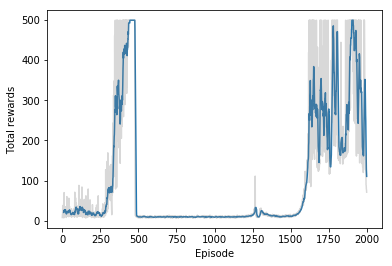

In [39]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

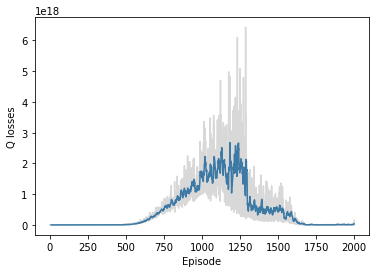

In [40]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

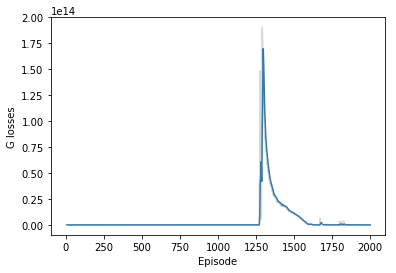

In [41]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

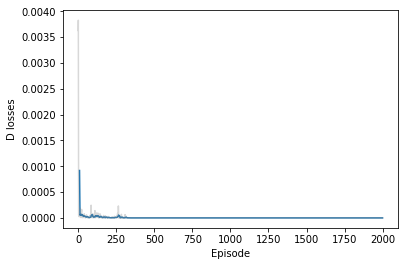

In [42]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.